# Logging & Exporting Time‑Series Results in pandapipes with `OutputWriter`

This tutorial shows how to:

- build a small pandapipes network,
- run a **quasi‑static time series** using `ConstControl`,
- **log and export** results with `OutputWriter` (CSV),
- post‑process the logged results (read back & plot).

> **Background**: `OutputWriter` is part of the pandapower time‑series engine and is reused by pandapipes.  
> In recent versions of pandapipes, the default initialization can **skip non‑existent components** when configuring
> log variables (so you don’t have to log e.g. `res_source` if there is no `source` in the net).  
> Below we also show how to define a **custom** `OutputWriter` explicitly.


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandapipes as pp
from pandapower.control import ConstControl

# OutputWriter comes from pandapower's time-series module
from pandapower.timeseries.output_writer import OutputWriter

# run_timeseries import (path may differ slightly across versions)
try:
    from pandapipes.timeseries.run_time_series import run_timeseries
    from pandapipes.timeseries.run_time_series import init_time_series  # optional import if you want to inspect internals
except Exception:
    # fallback if your installed pandapipes exposes it here:
    from pandapipes.timeseries import run_timeseries

## 1) Build a tiny water network

We'll create a minimal two‑junction network with an external grid, one pipe, and a single sink.


In [2]:
# Create empty network with water as the working fluid
net = pp.create_empty_network(fluid="water")

# Junctions
j0 = pp.create_junction(net, pn_bar=3.0, tfluid_k=293.15, height_m=0.0, name="Junction 0")
j1 = pp.create_junction(net, pn_bar=3.0, tfluid_k=293.15, height_m=0.0, name="Junction 1")

# External grid (supply) at j0
eg = pp.create_ext_grid(net, junction=j0, p_bar=3.0, t_k=293.15, name="Ext Grid")

# Pipe from j0 -> j1
pipe = pp.create_pipe_from_parameters(
    net, from_junction=j0, to_junction=j1,
    length_km=0.3, diameter_m=0.15, k_mm=0.2, sections=1, name="Pipe 0"
)

# A sink at j1 (initial value; this will be overwritten by the time series controller)
sink = pp.create_sink(net, junction=j1, mdot_kg_per_s=0.30, name="Sink 0")

# Quick static run to verify model consistency
pp.pipeflow(net)

# Show static results
print("res_junction columns:", list(net.res_junction.columns))
print(net.res_junction.head())
print("\nres_pipe columns:", list(net.res_pipe.columns))
print(net.res_pipe.head())

res_junction columns: ['p_bar', 't_k']
      p_bar     t_k
0  3.000000  293.15
1  2.999867  293.15

res_pipe columns: ['v_mean_m_per_s', 'p_from_bar', 'p_to_bar', 't_from_k', 't_to_k', 't_outlet_k', 'mdot_from_kg_per_s', 'mdot_to_kg_per_s', 'vdot_m3_per_s', 'reynolds', 'lambda']
   v_mean_m_per_s  p_from_bar  p_to_bar  t_from_k  t_to_k  t_outlet_k  \
0        0.017008         3.0  2.999867    293.15  293.15      293.15   

   mdot_from_kg_per_s  mdot_to_kg_per_s  vdot_m3_per_s     reynolds   lambda  
0                 0.3              -0.3       0.000301  2549.947017  0.04617  


## 2) Define a time series for the sink mass flow

We'll simulate **24 hourly steps** of a day. The sink mass flow follows a simple daily profile
(peaks around midday). You can replace this with real data at any time.


In [3]:
n_ts = 24
time_steps = list(range(n_ts))

# Simple bell-ish daily profile between 0.05 and 0.6 kg/s
base = 0.30
amp  = 0.25
hours = np.arange(n_ts)
profile = base + amp * np.clip(np.sin((hours - 6) / 24 * 2*np.pi), 0, None)

df_sink = pd.DataFrame(
    profile.reshape(-1, 1),
    index=time_steps,
    columns=[net.sink.index[0]]  # IMPORTANT: column name should match element index
)

print(profile[:12])   # first half of the day
print(profile[12:])   # second half


[0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.36470476 0.425      0.4767767  0.51650635 0.54148146]
[0.55       0.54148146 0.51650635 0.4767767  0.425      0.36470476
 0.3        0.3        0.3        0.3        0.3        0.3       ]


### Attach the profile with `ConstControl`

The `ConstControl` will, for each time step, write the sink mass flow from the DataFrame into `net.sink.mdot_kg_per_s`.
We pass the `DataFrame` directly via `data_source`. (Internally, pandapower uses a `DFData` wrapper.)


In [4]:
# In newer versions, ConstControl can directly take a DataFrame via the data_source argument.
# If your version expects a DataSource, you can wrap with DFData:
try:
    from pandapower.timeseries.data_sources.frame_data import DFData
    ds = DFData(df_sink)
except Exception:
    ds = df_sink  # some versions accept a DataFrame directly

ctrl = ConstControl(
    net,
    element='sink',
    variable='mdot_kg_per_s',
    element_index=net.sink.index,
    profile_name=list(df_sink.columns),  # must match DataFrame columns
    data_source=ds
)

print("Created ConstControl. Controlled element indices:", list(ctrl.element_index))

Created ConstControl. Controlled element indices: [0]


## 3A) Minimal path: use the **default OutputWriter**

If you **do not** configure an `OutputWriter` manually, `run_timeseries` initializes a default one.
Recent pandapipes versions may **only log variables for components that exist** in your net.

Let's run the time series with the default OutputWriter to get a feel for it.


In [8]:
# Run the time series (uses the default output writer internally)
run_timeseries(net, time_steps=time_steps, verbose=True)

# After the run, you can access the OutputWriter via net.output_writer
ow_auto = None
if "output_writer" in net and net.output_writer.iat[0, 0] is not None:
    ow_auto = net.output_writer.iat[0, 0]
    print("Default OutputWriter found on net.")
    # The in-memory 'output' dict contains at least a 'Parameters' DataFrame
    print("Output keys:", list(ow_auto.output.keys()))
    print(ow_auto.output["Parameters"].head())
else:
    print("No default OutputWriter was attached to the net in your version.")

100%|██████████| 24/24 [00:00<00:00, 134.50it/s]

Default OutputWriter found on net.
Output keys: ['Parameters', 'res_sink.mdot_kg_per_s', 'res_ext_grid.mdot_kg_per_s', 'res_pipe.v_mean_m_per_s', 'res_pipe.t_from_k', 'res_pipe.t_to_k', 'res_junction.p_bar', 'res_junction.t_k']
   time_step  controller_unstable  powerflow_failed
0          0                False             False
1          1                False             False
2          2                False             False
3          3                False             False
4          4                False             False


## 3B) Custom OutputWriter: choose what to log & where to save

Now let's configure our own `OutputWriter`:

- store results as **CSV** (`,` separator) into `./ow_results/`
- log:
  - junction pressure `res_junction.p_bar` (all junctions)
  - junction temperature `res_junction.t_k`
  - pipe mean velocity `res_pipe.v_mean_m_per_s`
  - sink mass flow `res_sink.mdot_kg_per_s`
  - (optionally) external grid mass flow `res_ext_grid.mdot_kg_per_s` if present


In [10]:
# Fresh run with a new network state (recreate controller to be explicit)
# NOTE: We reuse the same net and controller here; you could also rebuild from scratch.

# Configure a dedicated OutputWriter
out_dir = "ow_results"
os.makedirs(out_dir, exist_ok=True)

ow = OutputWriter(
    net,
    time_steps=time_steps,
    output_path=out_dir,
    output_file_type=".csv",
    csv_separator=",",
    log_variables=[] 
)

# Log variables (full tables by default; you can also pass 'index=[...]' to log subsets)
ow.log_variable('res_junction', 'p_bar')
ow.log_variable('res_junction', 't_k')
ow.log_variable('res_pipe', 'v_mean_m_per_s')
ow.log_variable('res_sink', 'mdot_kg_per_s')

# log external grid mass flow only if there is an ext_grid element
if len(net.ext_grid) > 0:
    ow.log_variable('res_ext_grid', 'mdot_kg_per_s')

# Attach it to the net so the time-series engine uses it
net.output_writer.iat[0, 0] = ow

# Re-run the time series with our custom OutputWriter
run_timeseries(net, time_steps=time_steps, verbose=True)

print("Finished time series. Files written to:", os.path.abspath(out_dir))
print("A quick peek at the directory:")

# Find CSV files in subfolders
csv_files = sorted(glob.glob(os.path.join(out_dir, "**", "*.csv"), recursive=True))

# Print the list (your original line)
print("\n".join(csv_files) or "(No CSV files found)")

# If files exist, also show their contents
if csv_files:
    for f in csv_files:
        print(f"\n===== {f} =====")
        df = pd.read_csv(f)
        print(df.head())   # show first 5 rows


100%|██████████| 24/24 [00:00<00:00, 216.25it/s]

Finished time series. Files written to: c:\Users\Afaq Jamshaid\Downloads\ow_results
A quick peek at the directory:
ow_results\res_ext_grid\mdot_kg_per_s.csv
ow_results\res_junction\p_bar.csv
ow_results\res_junction\t_k.csv
ow_results\res_pipe\v_mean_m_per_s.csv
ow_results\res_sink\mdot_kg_per_s.csv

===== ow_results\res_ext_grid\mdot_kg_per_s.csv =====
   Unnamed: 0    0
0           0 -0.3
1           1 -0.3
2           2 -0.3
3           3 -0.3
4           4 -0.3

===== ow_results\res_junction\p_bar.csv =====
   Unnamed: 0    0         1
0           0  3.0  2.999867
1           1  3.0  2.999867
2           2  3.0  2.999867
3           3  3.0  2.999867
4           4  3.0  2.999867

===== ow_results\res_junction\t_k.csv =====
   Unnamed: 0       0       1
0           0  293.15  293.15
1           1  293.15  293.15
2           2  293.15  293.15
3           3  293.15  293.15
4           4  293.15  293.15

===== ow_results\res_pipe\v_mean_m_per_s.csv =====
   Unnamed: 0         0
0        

## 4) Inspect the exported results

The `OutputWriter` writes one CSV **per logged variable**. Let's read a few back and plot them.


<Figure size 640x480 with 0 Axes>

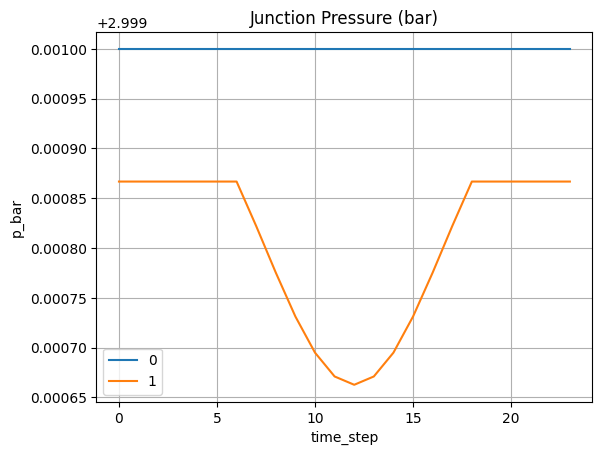

<Figure size 640x480 with 0 Axes>

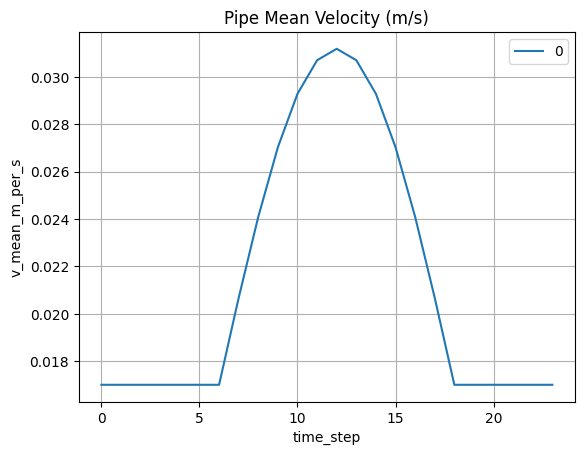

<Figure size 640x480 with 0 Axes>

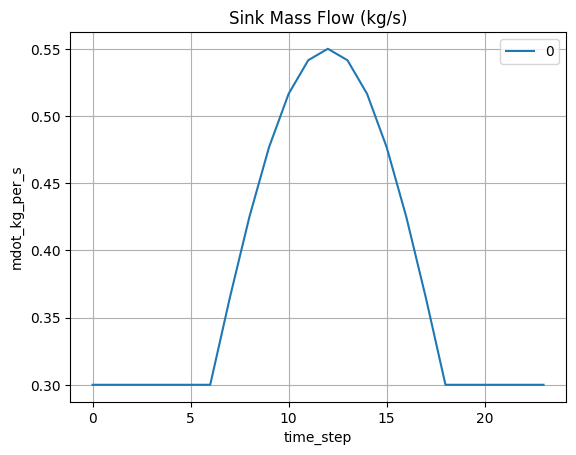

In [12]:
def read_logged_csv(out_dir, table, variable):
    """
    Reads a logged CSV file from the OutputWriter structure.
    Assumes files are stored inside subfolders like:
    out_dir/res_junction/p_bar.csv
    out_dir/res_sink/mdot_kg_per_s.csv
    """
    candidates = glob.glob(os.path.join(out_dir, table, f"{variable}*.csv"))
    if not candidates:
        raise FileNotFoundError(f"No CSV found for {table}.{variable} in {out_dir}")
    return pd.read_csv(candidates[0], index_col=0)

# Read back a few result tables
df_p = read_logged_csv(out_dir, "res_junction", "p_bar")
df_t = read_logged_csv(out_dir, "res_junction", "t_k")
df_v = read_logged_csv(out_dir, "res_pipe", "v_mean_m_per_s")
df_m = read_logged_csv(out_dir, "res_sink", "mdot_kg_per_s")

# Plot (one figure per chart, no explicit colors/styles)
plt.figure()
df_p.plot()
plt.title("Junction Pressure (bar)")
plt.xlabel("time_step")
plt.ylabel("p_bar")
plt.grid(True)

plt.figure()
df_v.plot()
plt.title("Pipe Mean Velocity (m/s)")
plt.xlabel("time_step")
plt.ylabel("v_mean_m_per_s")
plt.grid(True)

plt.figure()
df_m.plot()
plt.title("Sink Mass Flow (kg/s)")
plt.xlabel("time_step")
plt.ylabel("mdot_kg_per_s")
plt.grid(True)


## 5) Selective logging & aggregations (optional)

You can log **only a subset** of indices or **aggregated** values using `index` and `eval_function`:

```python
# log only junction j1 pressure:
ow.log_variable('res_junction', 'p_bar', index=[j1])

# log maximum pipe velocity across all pipes:
import pandas as pd
ow.log_variable('res_pipe', 'v_mean_m_per_s', eval_function=pd.Series.max, eval_name='v_max')
```

This is handy for large networks and reduces the size of exported files.


## Notes on robustness & common pitfalls

- **OutputWriter comes from pandapower**:  
  Since pandapipes reuses pandapower’s `OutputWriter`, some defaults (e.g. `res_bus`) do not apply to pandapipes.

- **Always start clean**:  
  When creating a custom `OutputWriter`, pass

  ```python
  log_variables=[]
  ```

  to avoid pandapower-specific defaults that can cause `KeyError: 'bus'`.

- **Check before logging**:
  Only log variables for components that actually exist in your net, e.g.

  ```python
  if len(net.sink) > 0:
      ow.log_variable("res_sink", "mdot_kg_per_s")
  ```

- **Selective & aggregated logging**:
  You can reduce file size or focus on key values:

  ```python
  ow.log_variable("res_junction", "p_bar", index=[0])                 # single element
  ow.log_variable("res_pipe", "v_mean_m_per_s", eval_function=pd.max) # aggregate
  ```

- **CSV structure**:
  By default, results are saved in subfolders (`res_junction/p_bar.csv`, …).
  Use `recursive=True` when searching for CSVs with `glob`.

- **Memory vs. disk**:
  Results are available both in-memory (`ow.output`) and written to CSVs after `run_timeseries`.
